In [1]:
import os
import numpy as  np
import matplotlib.pyplot as plt
import json
import config
from matplotlib.path import Path
import cv2




In [22]:
config.IMAGE_DIRECTORY

'/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/buts'

In [23]:
def resize_image(directory):
    '''
    resizes the images in directory according to dimensions in the config file.
    Args: directory(str)
    
    '''
    for filename in os.listdir(directory):
        if filename.split('.')[1] == 'jpg':
            filename = os.path.join(directory , filename)
            img = cv2.imread(filename)
            img = cv2.resize(img , (config.IMG_HEIGHT , config.IMG_WIDTH))
            cv2.imwrite(filename , img)

In [24]:
def rename_files(file_directory):
    ''' 
    renames the file names in image directory in this format -> cgrt_0.jpg , cgrt_1.jpg .... 
    Args: file_directory 

    '''
    i = 1
    for filename in os.listdir(file_directory):
        if filename.split('.')[1] == 'jpg':
            filename = os.path.join(file_directory , filename)
            renamed_file = os.path.join(file_directory , f'cgrt_{i}.jpg')
            print(filename , "   " ,  renamed_file)
            os.rename(filename , renamed_file)
            i+=1


In [25]:
def generate_mask(filename , json_file):
    '''
    generates a binary mask as ground truth for each image.
    Args: json_file
    '''

    with open(json_file, "r") as read_file:
        data = json.load(read_file)
    shapes = data['shapes']

    polygons = dict()
    for polygon_index in range(len(shapes)):
        polygons[polygon_index] = shapes[polygon_index]['points']
    
    for points in polygons:
        for index in range(len(polygons[points])):
            polygons[points][index][0] = round(polygons[points][index][0])
            polygons[points][index][1] = round(polygons[points][index][1]) 
            polygons[points][index] = tuple(polygons[points][index])

    print(polygons)
    x, y = np.meshgrid(np.arange(config.IMG_WIDTH), np.arange(config.IMG_HEIGHT))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T
    grid = np.zeros(config.IMG_HEIGHT*config.IMG_WIDTH)
    for polygon in polygons:
        path = Path(polygons[polygon])
        grid = grid.astype(float)
        grid += path.contains_points(points).astype(float)
        
    grid = grid.reshape((config.IMG_HEIGHT, config.IMG_WIDTH))
    grid = grid.astype(bool).astype(float)

    mask_file_name = os.path.join(config.MASK_DIRECTORY, filename.split('.')[0])
    print(mask_file_name)
    np.save(mask_file_name , grid)



In [26]:
def crop_images(directory_path):
    '''
    for a given directory crop images from bottom to get rid of noise that we had because of camera.
    Args: directory_path(str)
    '''
    for image_path in os.listdir(directory_path):
        image_path = os.path.join(directory_path , image_path)
        _crop_images(image_path)



def _crop_images(image_path):
    '''
    for a given path crop image from bottom to get rid of noise that we had because of camera.
    Args: image_path(str)
    '''
    img = plt.imread(image_path)
    crop_img = img[:config.IMG_HEIGHT - 30, :] # [height , width]
    plt.imsave(image_path, crop_img)

In [27]:
def generate_img_over_bg(image_path , mask_path , bg_image_path):
    '''
    project a segmented objects over background image
    Args: image_path(str) , mask_path(str) , bg_image_path(str)
    '''
    img = plt.imread(image_path)
    mask = np.load(mask_path)
    bg_img = plt.imread(bg_image_path)

    positions = np.where(mask > 0)
    merged = np.zeros((config.IMG_HEIGHT , config.IMG_WIDTH , 3))
    merged = bg_img.copy()
    for pos_x , pos_y in zip(positions[0] , positions[1]):
        merged[pos_x , pos_y] = img[pos_x , pos_y]

    plt.imsave('../out/image/buts/merged_4.jpg' , merged)

In [30]:
crop_images('../out/image/bg')

In [31]:
rename_files(config.IMAGE_DIRECTORY)


/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/buts/asdddddd.jpg     /home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/buts/cgrt_1.jpg
/home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/buts/babab.jpg     /home/elmar/Cigarette_buts_detection/cigarette_buts/out/image/buts/cgrt_2.jpg


In [32]:
resize_image(config.IMAGE_DIRECTORY)
resize_image(config.BACKGROUND_DIRECTORY)

In [33]:
generate_mask('cgrt_1.jpg', '../out/image/buts/cgrt_1.json')
generate_mask('cgrt_2.jpg', '../out/image/buts/cgrt_2.json')


FileNotFoundError: [Errno 2] No such file or directory: '../out/image/buts/cgrt_1.json'

In [12]:
mask = np.load('../out/mask/cgrt_2.npy')
img = plt.imread("../out/image/buts/cgrt_2.jpg")

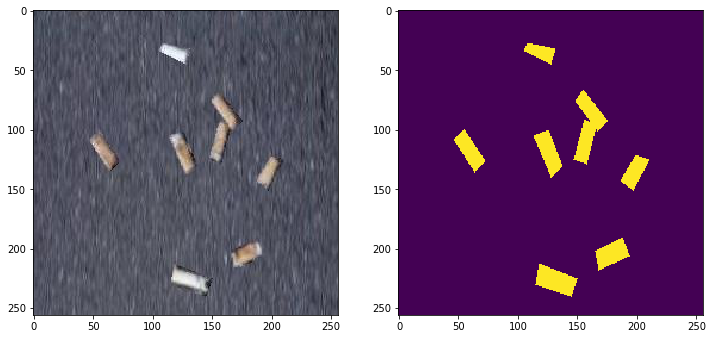

In [13]:
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(mask)

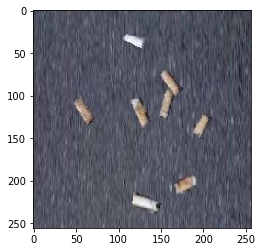

In [14]:
test = plt.imread('../out/image/buts/cgrt_2.jpg')
plt.imshow(test)

In [15]:
mask = np.load('../out/mask/cgrt_2.npy')
positions = np.where(mask > 0)
positions

(array([ 28,  28,  28, ..., 239, 239, 240]),
 array([108, 109, 110, ..., 144, 145, 145]))

In [16]:
new_img = np.zeros((256 , 256 , 3))

In [17]:
for pos_x , pos_y in zip(positions[0] , positions[1]):
    new_img[pos_x , pos_y] = img[pos_x , pos_y]
    
new_img = new_img.astype(np.uint8)
 # new_img[pos[0] , pos[1]]
    # print(pos_x , pos_y)


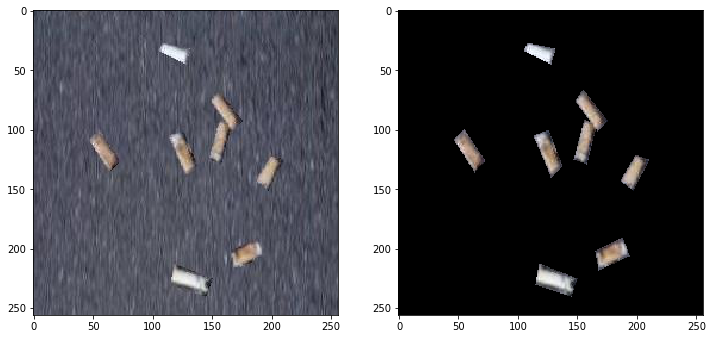

In [18]:
fig, ax = plt.subplots(1 , 2, figsize=(12, 8))
ax[0].imshow(img)
ax[1].imshow(new_img)

In [29]:
generate_img_over_bg('../out/image/buts/cgrt_2.jpg' ,'../out/mask/cgrt_2.npy' ,  '../out/image/bg/bg.jpg')

FileNotFoundError: [Errno 2] No such file or directory: '../out/image/buts/cgrt_2.jpg'

In [20]:
_crop_images('../out/image/bg/bg_1.jpg')

In [16]:
import sqlite3


def execute(query, payload=None, con=None):
    try:
        cursor = con.cursor()
        if payload:
            cursor.execute(query, payload)
        else:
            cursor.execute(query)
        res = cursor.fetchall()
        con.commit()
        cursor.close()
        return [dict(row) for row in res]
    except Exception as e:
        con.rollback()
        raise e


# CTIS_MAIN_TABLE = "tile"
def connect_CTIS(ctis_path):
    con = sqlite3.connect(ctis_path)
    con.row_factory = sqlite3.Row
    return con

In [17]:
con = connect_CTIS(ctis_path='/home/elmar/Cigarette_buts_detection/cigarette_buts/cigarettNet/buts.db')

In [24]:
con.execute('''CREATE TABLE IF NOT EXISTS paths
             (image_path text, mask_path text, json_path text)''')

In [44]:
con.execute('''INSERT INTO students
             VALUES(1, 'elmar', 21)''')


In [62]:
con.commit()

In [61]:
def add_Path(image_path, mask_path, json_path):
    p1 = '"{}"'.format(image_path)
    p2 = '"{}"'.format(mask_path)
    p3 = '"{}"'.format(json_path)

    con.execute("INSERT INTO paths VALUES(" +p1+','+p2+','+p3+')')
    





addPath('nihad', 'elamr','canavar')






"nihad"


In [122]:
def load_paths(conn,json_path= False, limit=False):
    paths =[]
    cur = conn.cursor()
    if json_path:
        cur.execute("SELECT image_path,mask_path, json_path FROM paths")
        rows = cur.fetchall()
        for row in rows:
            lst = []
            for i in row:
                lst.append(i)
            paths.append(lst)

    else:
        cur.execute("SELECT image_path,mask_path FROM paths")
    rows = cur.fetchall()
 
    return paths

In [120]:
def select_all_tasks(conn):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """
    cur = conn.cursorows = cur.fetchall()r()
    cur.execute("SELECT * FROM paths")
 
    rows = cur.fechall()
 
    for row in rows:
        print(row[0] , row[1] , row[2])

SyntaxError: invalid syntax (<ipython-input-120-58aefb839a11>, line 7)

In [123]:
paths = load_paths(con, json_path =True)
print(paths)

[['image_path', 'mask_path', 'json_path'], ['path1', 'path2', 'path3'], ['path1', 'path2', 'path3'], ['a', 'b', 'c'], ['nihad', 'elamr', 'canavar']]
